In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
!pip -qq install pykrige shapely polire psutil
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.cluster import KMeans
import scipy
import matplotlib.pyplot as plt
from polire.interpolate import Kriging
import psutil
import multiprocessing as mp
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')

from NSGPy.NumPy import LLS

## Beijing Data

In [3]:
if not os.path.exists('beijing_AQI.csv'):
    os.system('wget --no-check-certificate https://raw.githubusercontent.com/patel-zeel/Nonstat-exps/main/data/beijing/beijing_AQI.csv')

## Pre-processing

In [4]:
df = pd.read_csv('beijing_AQI.csv')
df = df.set_index('time').sort_index()
print('unique timestamps are',len(df.index.unique()))
useful_ts = []
for ts in df.index.unique():
  if(len(df.loc[ts])==36):
    useful_ts.append(ts)
df = df.loc[useful_ts]
print('unique timestamps after removing missing entry time-stamps are',len(useful_ts))
df.columns

unique timestamps are 7460
unique timestamps after removing missing entry time-stamps are 2132


Index(['station_id', 'temperature', 'pressure', 'humidity', 'wind_speed',
       'PM25_Concentration', 'latitude', 'longitude', 'weather_0', 'weather_1',
       'weather_10', 'weather_11', 'weather_12', 'weather_13', 'weather_14',
       'weather_15', 'weather_16', 'weather_2', 'weather_3', 'weather_4',
       'weather_5', 'weather_6', 'weather_7', 'weather_8', 'weather_9',
       'wind_direction_0', 'wind_direction_1', 'wind_direction_13',
       'wind_direction_14', 'wind_direction_2', 'wind_direction_23',
       'wind_direction_24', 'wind_direction_3', 'wind_direction_4',
       'wind_direction_9'],
      dtype='object')

## Visualizing data samples

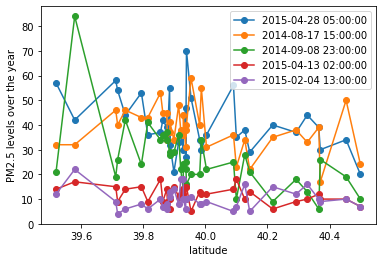

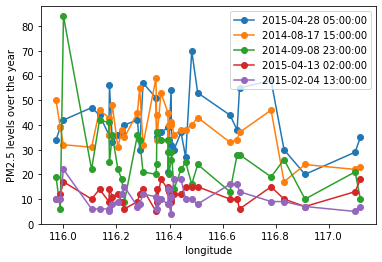

In [5]:
N = 5
sample_ts = df.sample(5, random_state=0).index
for ts in sample_ts:
  tmp_df = df.loc[ts].sort_values('latitude')
  plt.plot(tmp_df.latitude, tmp_df.PM25_Concentration,'o-', label=str(ts))
plt.legend()
plt.xlabel('latitude')
plt.ylabel('PM2.5 levels over the year');

plt.figure()
for ts in sample_ts:
  tmp_df = df.loc[ts].sort_values('longitude')
  plt.plot(tmp_df.longitude, tmp_df.PM25_Concentration,'o-',  label=str(ts))
plt.legend()
plt.xlabel('longitude')
plt.ylabel('PM2.5 levels over the year');

## Train, test split, random state 0

In [6]:
train_stations, test_stations = train_test_split(df.loc[df.index[0]].station_id, 
                                                 train_size=0.85, 
                                                 random_state=0)
print('train_stations', len(train_stations))
print('test_stations', len(test_stations))
df_train = df[df.station_id.isin(train_stations)]
df_test = df[df.station_id.isin(test_stations)]

train_stations 30
test_stations 6


# Experiment for 24 time-stamps

In [7]:
n_ts = 24

# Logitude

## Kriging

variogram model = linear
Euclidean mean rmse 24.17874943220619 std 13.452436022141887
------------------------------
variogram model = linear
Geographic mean rmse 24.17874943220619 std 13.452436022141887
------------------------------
variogram model = power
Euclidean mean rmse 24.47541724723003 std 13.777218115133575
------------------------------
variogram model = power
Geographic mean rmse 24.47541724723003 std 13.777218115133575
------------------------------
variogram model = gaussian
Euclidean mean rmse 24.09426591803175 std 13.225642548622954
------------------------------
variogram model = gaussian
Geographic mean rmse 24.09426591803175 std 13.225642548622954
------------------------------
variogram model = spherical
Euclidean mean rmse 23.247929899362884 std 13.308077152456653
------------------------------
variogram model = spherical
Geographic mean rmse 23.247929899362884 std 13.308077152456653
------------------------------
variogram model = exponential
Euclidean mean rmse 

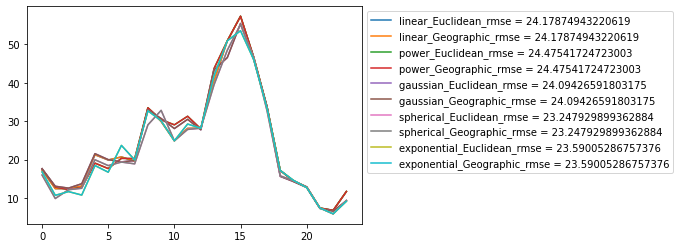

In [8]:
# linear, power, gaussian, spherical, exponential
def krige_it(x):
    ts, (vario, cord) = x
    model = Kriging(variogram_model=vario, coordinate_type=cord)
    if ts == df_train.index[0]:
        print('variogram model =', model.variogram_model)
    model.fit(np.concatenate([df_train.loc[ts][['longitude']].values, np.zeros((len(df_train.loc[ts]),1))], axis=1), 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(np.concatenate([df_test.loc[ts][['longitude']].values, np.zeros((len(df_test.loc[ts]),1))], axis=1))
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred.filled()

for vario in ['linear','power','gaussian','spherical','exponential']:
    for cord in ['Euclidean', 'Geographic']:
        workers = mp.Pool(psutil.cpu_count())
        ans = workers.map(krige_it, zip(df.index.unique()[:n_ts], [(vario, cord)]*n_ts))
        mse = list(map(lambda x:x[0], ans))
        plt.plot(mse, label=vario+'_'+cord+'_rmse = '+str(np.mean(mse)))
        print(cord, 'mean rmse',np.mean(mse),'std', np.std(mse))
        print('-'*30)
        workers.terminate()
plt.legend(bbox_to_anchor=[1,1]);

## Stationary GP - RBF

mean rmse 24.965262202268843 std 13.734377398362836
------------------------------


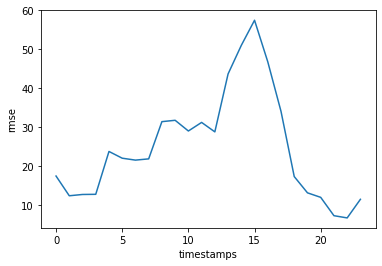

In [9]:
def GP_it(ts):
    model = GaussianProcessRegressor(C()*RBF()+WhiteKernel(), n_restarts_optimizer=5, random_state=0)
    model.fit(df_train.loc[ts][['longitude']].values, 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(df_test.loc[ts][['longitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

workers = mp.Pool(psutil.cpu_count())
ans = workers.map(GP_it, df.index.unique()[:n_ts])
mse = list(map(lambda x:x[0], ans))
plt.plot(mse)
plt.xlabel('timestamps');plt.ylabel('rmse')
print('mean rmse',np.mean(mse),'std', np.std(mse))
print('-'*30)
workers.terminate()

## Stationary GP - Matern

mean 24.87978999634949 std 13.667300627545286
------------------------------


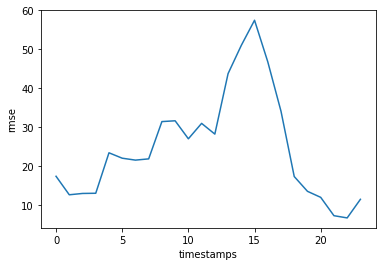

In [10]:
def GP_it(ts):
    model = GaussianProcessRegressor(C()*Matern()+WhiteKernel(), n_restarts_optimizer=5, random_state=0)
    model.fit(df_train.loc[ts][['longitude']].values, 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(df_test.loc[ts][['longitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

workers = mp.Pool(psutil.cpu_count())
ans = workers.map(GP_it, df.index.unique()[:n_ts])
mse = list(map(lambda x:x[0], ans))
plt.plot(mse)
plt.xlabel('timestamps');plt.ylabel('rmse')
print('mean',np.mean(mse),'std', np.std(mse))
print('-'*30)
workers.terminate()

## Non-Stat GP

Started job for N = 1
job finished in 0.013664674758911134 minutes
mean 24.43380795416427 std 14.172140957751846
------------------------------
Started job for N = 2
job finished in 0.010698950290679932 minutes
mean 24.576076964315273 std 13.484019493070885
------------------------------
Started job for N = 3


LinAlgError: Matrix is not positive definite

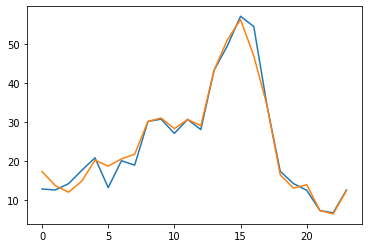

In [14]:
def LLS_it(x):
    ts, N = x
    model = LLS(1, N_l_bar=N, seed=42)
    model.fit(df_train.loc[ts][['longitude']].values, 
            df_train.loc[ts][['PM25_Concentration']].values)
    pred, _ = model.predict(df_test.loc[ts][['longitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    #print('model, N=',N,'ts=', ts)
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

for N in [1,2,3,4,5]:
    print('Started job for N =',N)
    init = time()
    workers = mp.Pool(psutil.cpu_count())
    ans = workers.map(LLS_it, zip(df.index.unique()[:n_ts], [N]*n_ts))
    pd.to_pickle(ans, str(N)+'.pickle')
    print('job finished in',(time()-init)/60,'minutes')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))
    print('mean',np.mean(mse),'std', np.std(mse))
    print('-'*30)
    workers.terminate()
plt.legend(bbox_to_anchor=(1,1))

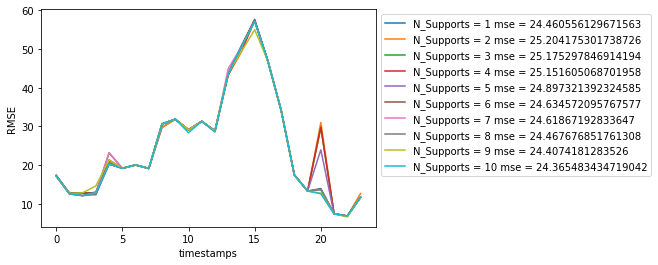

In [14]:
for N in [1,2,3,4,5,6,7,8,9,10]:
    ans = pd.read_pickle(str(N)+'.pickle')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))

plt.xlabel('timestamps')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1,1));

# Latitude

## Kriging

variogram model = linear
Euclidean mean rmse 25.05653267061145 std 14.125390756146254
------------------------------
variogram model = linear
Geographic mean rmse 25.05653267061145 std 14.125390756146254
------------------------------
variogram model = power
Euclidean mean rmse 25.03245421092679 std 15.411710573138844
------------------------------
variogram model = power
Geographic mean rmse 25.03245421092679 std 15.411710573138844
------------------------------
variogram model = gaussian
Euclidean mean rmse 30.340602457163442 std 24.69204466198352
------------------------------
variogram model = gaussian
Geographic mean rmse 30.340602457163442 std 24.69204466198352
------------------------------
variogram model = spherical
Euclidean mean rmse 26.434603732892295 std 15.165531599746638
------------------------------
variogram model = spherical
Geographic mean rmse 26.434603732892295 std 15.165531599746638
------------------------------
variogram model = exponential
Euclidean mean rmse 

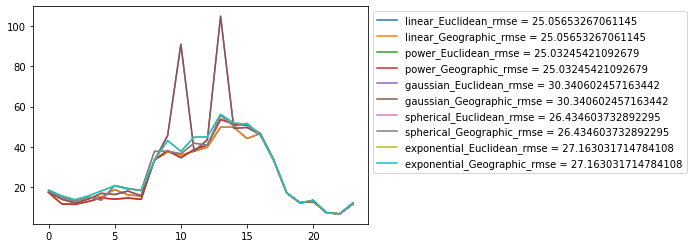

In [15]:
# linear, power, gaussian, spherical, exponential
def krige_it(x):
    ts, (vario, cord) = x
    model = Kriging(variogram_model=vario, coordinate_type=cord)
    if ts == df_train.index[0]:
        print('variogram model =', model.variogram_model)
    model.fit(np.concatenate([df_train.loc[ts][['latitude']].values, np.zeros((len(df_train.loc[ts]),1))], axis=1), 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(np.concatenate([df_test.loc[ts][['latitude']].values, np.zeros((len(df_test.loc[ts]),1))], axis=1))
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred.filled()

for vario in ['linear','power','gaussian','spherical','exponential']:
    for cord in ['Euclidean', 'Geographic']:
        workers = mp.Pool(psutil.cpu_count())
        ans = workers.map(krige_it, zip(df.index.unique()[:n_ts], [(vario, cord)]*n_ts))
        mse = list(map(lambda x:x[0], ans))
        plt.plot(mse, label=vario+'_'+cord+'_rmse = '+str(np.mean(mse)))
        print(cord, 'mean rmse',np.mean(mse),'std', np.std(mse))
        print('-'*30)
        workers.terminate()
plt.legend(bbox_to_anchor=[1,1]);

## Stationary GP - RBF

mean rmse 23.999464483315936 std 14.95543948217547
------------------------------


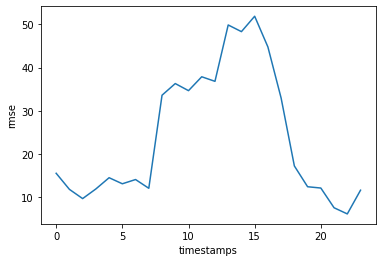

In [16]:
def GP_it(ts):
    model = GaussianProcessRegressor(C()*RBF()+WhiteKernel(), n_restarts_optimizer=5, random_state=0)
    model.fit(df_train.loc[ts][['latitude']].values, 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(df_test.loc[ts][['latitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

workers = mp.Pool(psutil.cpu_count())
ans = workers.map(GP_it, df.index.unique()[:n_ts])
mse = list(map(lambda x:x[0], ans))
plt.plot(mse)
plt.xlabel('timestamps');plt.ylabel('rmse')
print('mean rmse',np.mean(mse),'std', np.std(mse))
print('-'*30)
workers.terminate()

## Stationary GP - Matern

mean 24.019788496135856 std 14.727964785038878
------------------------------


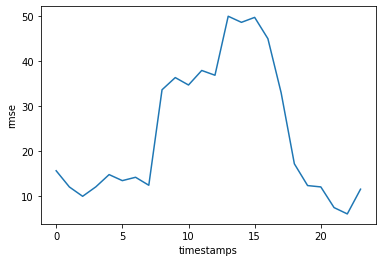

In [17]:
def GP_it(ts):
    model = GaussianProcessRegressor(C()*Matern()+WhiteKernel(), n_restarts_optimizer=5, random_state=0)
    model.fit(df_train.loc[ts][['latitude']].values, 
            df_train.loc[ts][['PM25_Concentration']])
    pred = model.predict(df_test.loc[ts][['latitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

workers = mp.Pool(psutil.cpu_count())
ans = workers.map(GP_it, df.index.unique()[:n_ts])
mse = list(map(lambda x:x[0], ans))
plt.plot(mse)
plt.xlabel('timestamps');plt.ylabel('rmse')
print('mean',np.mean(mse),'std', np.std(mse))
print('-'*30)
workers.terminate()

## Non-Stat GP

Started job for N = 1
Started job for N = 2
Started job for N = 3
Started job for N = 4
Started job for N = 5
Started job for N = 6
Started job for N = 7
Started job for N = 8
Started job for N = 9
Started job for N = 10


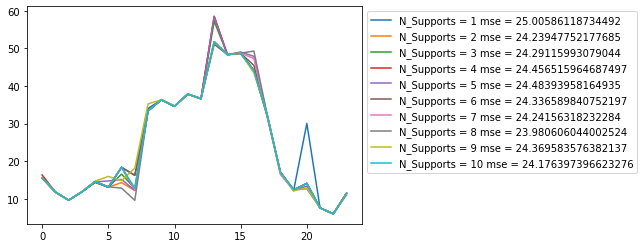

In [19]:
def LLS_it(x):
    ts, N = x
    model = LLS(1, N_l_bar=N)
    model.fit(df_train.loc[ts][['latitude']].values, 
            df_train.loc[ts][['PM25_Concentration']].values)
    pred, _ = model.predict(df_test.loc[ts][['latitude']].values)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    #print('model, N=',N,'ts=', ts)
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred

for N in [1,2,3,4,5,6,7,8,9,10]:
    print('Started job for N =',N)
    init = time()
    workers = mp.Pool(psutil.cpu_count())
    ans = workers.map(LLS_it, zip(df.index.unique()[:n_ts], [N]*n_ts))
    pd.to_pickle(ans, str(N)+'_lat.pickle')
    #print('job finished in',(time()-init)/60,'minutes')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))
    #print('mean',np.mean(mse),'std', np.std(mse))
    #print('-'*30)
    workers.terminate()
plt.legend(bbox_to_anchor=(1,1))

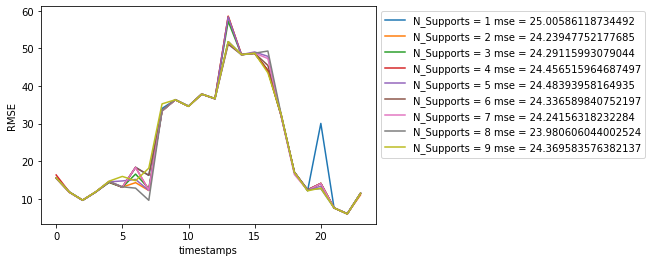

In [21]:
for N in [1,2,3,4,5,6,7,8,9]:
    ans = pd.read_pickle(str(N)+'_lat.pickle')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))

plt.xlabel('timestamps')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1,1));